In [2]:
using LinearAlgebra
using Statistics
using Plots

In [3]:
# helper methods
function symetric_matrix(dim::Integer, show_matrix=false::Bool)::Matrix
    A = ones(dim,dim);
    for i = 1:dim
        for j = 1:dim
            A[i,j] = rand(1:50);
            A[j,i] = A[i,j];
        end
    end
    if show_matrix
        display(A);
    end
    return A;
end

# we might change it to just rand(dim,dim)
function random_matrix(dim::Integer, show_matrix=false::Bool)::Matrix
    A = ones(dim, dim);
    for i = 1:dim
        for j = 1:dim
            A[i,j] = rand(1:50);
        end
    end
    if show_matrix
        display(A);
    end
    return A
end

function diagonal_matrix(dim::Integer)::Matrix
    Diag = ones(dim,dim)
    return Diagonal(Diag)
end

function custom_cond(λₘₐₓ, λₘᵢₙ)
    return sqrt(λₘₐₓ/λₘᵢₙ)
end

custom_cond (generic function with 1 method)

# Metoda potęgowa

Poniżej przygotowana jest funkcja do metody iteracji prostej (metoda potęgowa), dzięki której można wyznaczyć największą co do modułu wartość własną, czyli promień spektralny macierzy, który opisany jest wzorem:
## $$\rho(A) = |\lambda_{max}| = \lim_{i \to \infty} \frac{||t_{i+1}||_{\infty}}{||t_{i}||_{\infty}}$$

Przy założeniu, że dowolny wektor początkowy t_{0} != 0, do uzyskania promienia spektralnego prowadzą iteracje postaci:
## $$t_{i+1} = At_{i},\ i=0,1,2...$$



In [4]:
function power_eigen(A::Matrix, iterations::Integer)::Array
    n = size(A, 1);
    X = ones(n,1);
    X1 = X;
    
    for i = 1:iterations
        X1 = X;
        X = A * X;
        X = X / norm(X);
    end
    return X' * A * X1 / (X' * X1);
end

function power_eigen_min(A::Matrix, iterations::Integer)::Array
    n = size(A, 1);
    X = ones(n,1);
    X1 = X;
    for i = 1:iterations
        X1 = X;
        X = A \ X;
        X = X / norm(X);
    end

    return X' * A * X1 / (X' * X1);
end

power_eigen_min (generic function with 1 method)

In [5]:
A = symetric_matrix(5);
#A = random_matrix(5);
#A = [22 21 -8 4; 21 49 11 39; -8 11 60 -19; 4 39 -19 135]
@time λₘₐₓ = power_eigen(A, 10);
display(λₘₐₓ);
e, v = eigen(A);
display(e);

1×1 Array{Float64,2}:
 135.03332768033306

5-element Array{Float64,1}:
 -52.5983684147464
 -32.16132826659537
  30.810405097992387
  42.915963904192296
 135.03332767915674

  2.493979 seconds (6.63 M allocations: 322.227 MiB, 5.24% gc time)


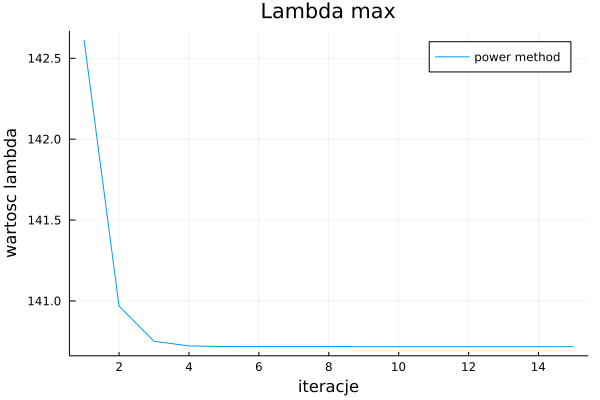

In [60]:
PlotA = symetric_matrix(5);
results = zeros(0);

plot_iterations = 15;
for i = 1:plot_iterations
    val = power_eigen(PlotA,i);
    append!(results, val);
end

x = 1:plot_iterations;
lambda_max_plot = plot(x, results, title= "Lambda max", label="power method", xlabel="iteracje", ylabel="wartosc lambda")

Jak widać z wyniku wykonania powyższego kodu, uzyskaliśmy największą co do modułu wartość własną macierzy. Ta wartość zgadza sięz wartością otrzymaną za pomocą metody eigen(A). Za pomocą metody potęgowej można również wyznaczyć najmniejszą co do modułu wartość własną macierzy. Korzysta się z twierdzenia dotyczącego przesunięcia spektrum macierzy:<br />
### "Jeżeli $\lambda$ jest wartością własną macierzy A, to $\lambda + r$ jest wartością własną macierzy $A + \tau I$"
Należy pamiętać, że twierdzenie ma zastosowanie dla macierzy symetrycznych i dodatnio określonych. Po zastosowaniu przesunięcia $B = A - \lambda_{max}I$ można ponownie zastosować metodę iteracji prostej dla macierzy B zbieżną do największej co do modułu wartości własnej $\lambda = \lambda_{min}-\lambda_{max}$. Stąd można wyznaczyć $\lambda_{min}$.

In [7]:
#Diag = diagonal_matrix(size(A,1))
#B = @. A - λₘₐₓ * Diag
#λ = power_eigen(B, 10);
#λₘᵢₙ = λ + λₘₐₓ
#print(λₘᵢₙ)
λₘᵢₙ = power_eigen_min(A,10)

1×1 Array{Float64,2}:
 165.4475562730103

Mając największą i najmniejszą wartość własną macierzy, można wyznaczyć współczynnik uwarunkowania macierzy:
$$cond(A)=\sqrt{\frac{\lambda_{max}(A^TA)}{\lambda_{min}(A^TA)}}$$
We wzorze przyjęto, że macierz A jest symetryczna, co oznacza, że $A=A^T$, ewentualnie można macierz wejściową doprowadzić do postaci symetrycznej stosując wzór $B = A^TA$

In [8]:
value = custom_cond(λₘₐₓ, λₘᵢₙ)
print(value)

cond(A)


[0.903421260470892]

4.382718346275674

# Metoda Jacobiego

In [9]:
function jacobi_eigen(A::Matrix, iterations::Integer)
    n = size(A,1);
    for i = 1:iterations
        s,t = maxst(A);
        
        d = √((A[s,s] - A[t,t])^2 + 4 * A[s,t]^2);
        sin2t = 2 * A[s,t] / d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = √(2 * (1 + cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1 + cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = diagonal_matrix(n);
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        
        A = R' * A * R; 
        
    end
    return A
end

function maxst(A::Matrix)
    s = 1;
    t = 2;
    n = size(A,1);
    for c = 2:n
        for r = 1:c-1
            if abs(A[r,c]) > abs(A[s,t])
                s = r;
                t = c;
            end
        end
    end
    return s, t
end

maxst (generic function with 1 method)

In [11]:
#F = [12 6 -6 1; 6 16 2 100; -6 2 16 1 ;1 100 1 4];
#F = rand(4,4);
F = symetric_matrix(5)
@time FJ = jacobi_eigen(F, 15);
#FJ[abs.(FJ) .< 1e-10] .= 0.0;
n = size(FJ,1);
for i = 1:n
    for j = 1:n
        if i != j
            FJ[i,j] = 0.0;
        end
    end
end
display(maximum(abs, FJ))

#display(FJ)
e,v = eigen(F);
display(e)


  0.000034 seconds

145.0261680587319

5-element Array{Float64,1}:
 -37.28887770501052
 -17.445860622498003
  23.20212083212496
  35.50395787747521
 145.02865961790812

 (75 allocations: 18.750 KiB)


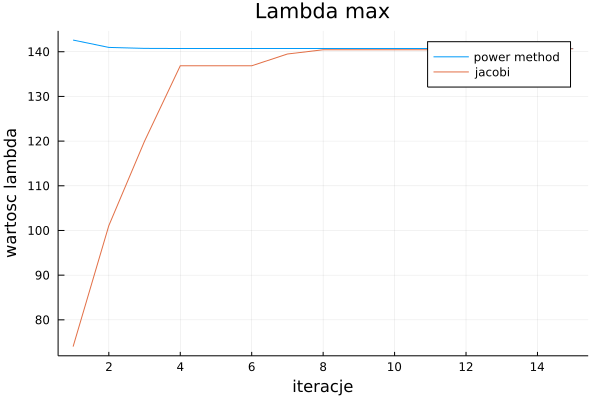

In [61]:
results = zeros(0);
for i = 1:plot_iterations
    PlotAJ = jacobi_eigen(PlotA, i);
    val = maximum(abs, PlotAJ)
    append!(results, val);
end

x = 1:plot_iterations;
plot!(lambda_max_plot, x, results, label="jacobi")
